In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time 

# 1. MDP definition

We consider the following MDP : a salesman can visit one of two towns (A and B) everyday.

The (deterministic) rewards for each town are $r_{A}$ and $r_{B}$. The cost of switching towns is $c$, and we assume that the travel is instanstaneaous. For example, the salesman moves from A to B in the morning, and works in B all day.

In [2]:
r_A = 2 #expected reward in town A
r_B = 1 #expected reward in town B
c   = 3 #cost for switchning towns
gamma=0.9 #discount factor

In [20]:
#Define a policy
p_a = 0.95 #probability of staying in town A
p_b = 0.95 #probability of staying in town B
P_pi = np.array([[p_a,1-p_a],[1-p_b,p_b]]) #corresponding transition matrix
print P_pi

#Compute the expected reward vector r_pi
r_pi = np.array([(r_A * P_pi[0,0]+(r_B-c)*P_pi[0,1]),
                 (r_B * P_pi[1,1]+(r_A-c)*P_pi[1,0])])
             
print "r_pi =", r_pi


[[ 0.95  0.05]
 [ 0.05  0.95]]
r_pi = [ 1.8  0.9]


Recall $v_{\pi}$ can be computed analytically using the following formula:
$$
v_{\pi} = (I - \gamma P_{\pi})^{-1} r_{\pi}
$$

In [23]:
#Compute value function analytically
#we use the explicif formula for 2x2 matrix
v_pi = np.dot(
    1/((1-gamma*P_pi[0,0])*(1-gamma*P_pi[1,1])-gamma*gamma*P_pi[0,1]*P_pi[1,0]) * 
    np.array([[1-gamma*P_pi[1,1],gamma*P_pi[0,1]],[gamma*P_pi[1,0],1-gamma*P_pi[0,0]]])
    ,r_pi)

#The following line can also be used
#v_pi = np.dot(np.linalg.inv(np.identity(2)-gamma*P_pi),r_pi)

print "v_pi = ", v_pi

v_pi =  [ 15.86842105  11.13157895]


# 2. Policy evaluation algorithm

In [11]:
#policy evaluation algorithm
def policy_evaluation(
                      gamma, #discount factor
                      P_pi, #transition matrix for policy pi
                      r_pi, #expected reward if policy pi is followed
                      v_init, #initial guess of the value function
                      v_pi, #true value function
                      theta=10**(-7), #convergence tolerance threshold (default 10^-7)
                      N_max=1000, #maximum number of iterations (default is 1000)
                      verbose=False #whether display messages or not (default is False)
                     ):
    if verbose :
        print "Running policy evaluation..."
    
    err=np.zeros(N_max+1) #approximation error, ie err_k = | v_k - v_pi |
    log_sigma=np.zeros(N_max+1) #logarithm of empirical average convergence rate
                                #we only record the logarithm for numerical stability
    var_err = np.zeros(N_max+1) #variation of the error, ie var_err_k = | err_k / err_{k-1} |
    V=np.zeros((N_max+1,np.size(v_pi))) #sequence of error vectors, ie V_k = v_k - v_pi
    
    #define initial value function
    v_approx= v_init
    v_temp = np.zeros(np.size(v_init)) #used to store updates of v_approx
    
    #initial error
    err[0] = np.max(np.abs(v_approx- v_pi))
    V[0,:]=v_approx-v_pi
    
    epsilon = theta+1 #perform at least one iteration
    count=1 #counts the number of iterations
    
    #=============================
    #  RUN POLICY EVALUATION
    #=============================
    
    while(epsilon>theta and count<=N_max):
        epsilon = 0
    
        #perform update
        v_temp = r_pi+gamma*np.dot(P_pi,v_approx) #one sweep
        #v_temp = r_pi+gamma*np.dot(P_pi,r_pi+gamma*np.dot(P_pi,v_approx)) #two sweeps
        #v_temp = r_pi+gamma*np.dot(P_pi,r_pi+gamma*np.dot(P_pi,r_pi+gamma*np.dot(P_pi,v_approx))) #3 sweeps
        
    
        #compute max change in the value function
        epsilon = np.max(np.abs(v_approx-v_temp))
        #update value function
        v_approx=v_temp
        V[count,:]=v_approx-v_pi
    
        #compute new error, error variation, and average convergence rate so far
        err[count] = np.max(np.abs(v_approx- v_pi))
        var_err[count]=err[count]/err[count-1]
        log_sigma[count] = (1.0/count) * (np.log(err[count])-np.log(err[0]))
        
        #increment iterations count
        count=count+1
    
    #termination message
    if verbose:
        if (count >N_max): #convergence failed
            print "\tReached max iterations (", N_max, ")"
            print "\tLast improvement:", epsilon, ">", theta
        else: #succesful convergence
            print "\tConvergence reached after", count-1, "iterations"
            print "\tLast improvement:", epsilon, "<", theta
    
    #free some space in memory
    err=err[range(count)]
    log_sigma = log_sigma[range(count)]
    var_err=var_err[range(count)]
    V=V[range(count),:]
    
    
    #un-comment the following line if you want to update the initial value function in place
    #in any case, the final value function is returned to caller
    #v_init = v_approx
    
    return (v_approx,err,var_err,log_sigma,V)

# 3. Numerical convergence

We set $v_{0} = 0$ and apply the policy evaluation algorithm

The graphs below display :
* The error $\epsilon_{k}$ at each iteration
* The error ratio $\dfrac{|\epsilon_{k+1}| }{ |\epsilon_{k}|}$
* The empirical average rate of convergence

Running policy evaluation...
	Convergence reached after 223 iterations
	Last improvement: 9.3795193834e-11 < 1e-10
Time : 0.00499987602234


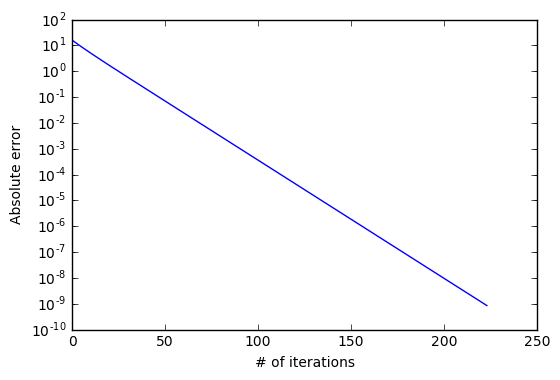

Empirical slope :  -0.045633184062
Theoretical slope: -0.0457574905607


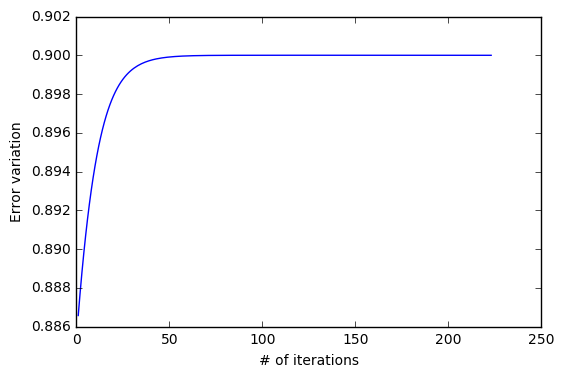

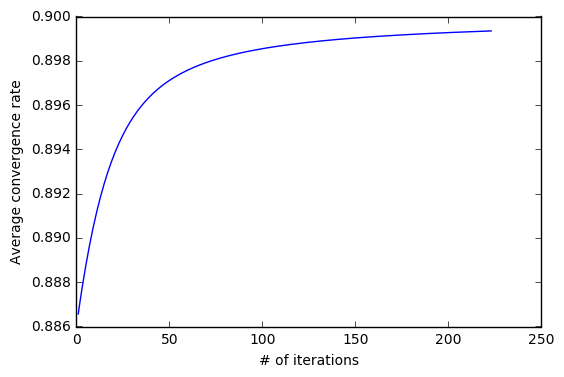

In [24]:
theta = 10 ** (-10) #convergence tolerance
N=1000 #maximum number of iterations
v_approx= np.array([0.0,0.0]) #initial guess

#perform policy evaluation
start=time.time()
(v_approx,err,var_err,log_sigma,V) = policy_evaluation(gamma, P_pi, r_pi, v_approx, v_pi,theta,N,True)
print 'Time :', time.time()-start



#plot convergence graphs
n=np.size(err)
    
#plot infinite norm of the error, in semi-log scale
plt.semilogy(range(n),err[range(n)])
plt.xlabel("# of iterations")
plt.ylabel("Absolute error")
plt.show()

#compute empirical slope
print "Empirical slope : ", (-np.log10(err[1])+np.log10(err[n-1]))/(n)
print "Theoretical slope:", np.log10(gamma)

#plot variation in the error norm
plt.plot(range(1,n),var_err[range(1,n)])
plt.xlabel("# of iterations")
plt.ylabel("Error variation")
plt.show()
    
#plot average rate of convergence
#See Section 3.2 of Varga - Matrix Iterative Analysis
plt.plot(range(1,n),np.exp(log_sigma[range(1,n)]),'b') #empirical
plt.xlabel("# of iterations")
plt.ylabel("Average convergence rate")
plt.show()

# 4. Convergence visualization in the eigenbasis of $P_{\pi}$

Recall the following iterative rule:
$$
\varepsilon_{k} = \gamma P_{\pi} e_{k-1} = \gamma^{k} P_{\pi}^{k} \varepsilon_{0}
$$

Assuming there exists an eigenbasis of $P_{\pi}$, then in this eigenbasis :
$$
\varepsilon_{k} =
\gamma^{k}
\left(
\begin{array}{ccc}
\lambda_{1}^{k} & 0 & 0 \\
0 & \ddots & 0 \\
0 & 0 & \lambda_{|S|}^{k}
\end{array}
\right)
\varepsilon_{0}
$$

Thus, if we project on eigenvector $w$ associated to eigenvalue $\lambda$, we expect the error to shrink geometrically, at rate $\gamma \lambda$

The first graph displays the successive error vectors $\epsilon_{k}=v_{k}-v_{\pi}$. The two eigenvectors of $P_{\pi}$ are also displayed. The second graph shows the projected error on each eigenspace.

In [25]:
#Compute eigenvalues of P_pi
(e,v)=np.linalg.eig(P_pi)
print e
print v
v[:,1]

[ 1.   0.9]
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


array([-0.70710678,  0.70710678])

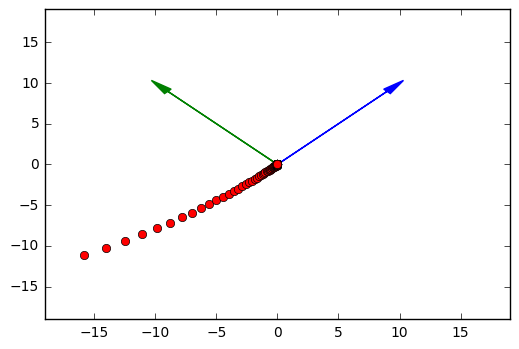

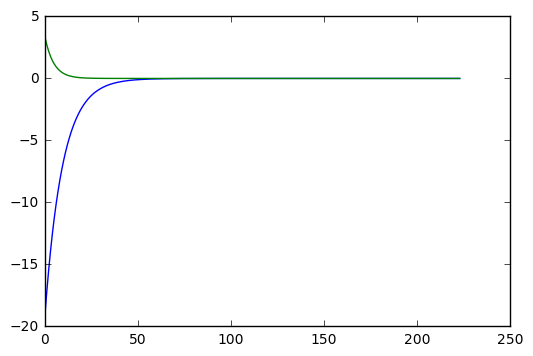

In [26]:
n=np.size(V[:,0])
x_max = 1.2*np.max(np.abs(V[0,:]))

#plot convergence of value function
plt.plot(V[:,0],V[:,1],'ro')
plt.plot([-x_max,-x_max], [x_max,x_max], color='b', linestyle='--')
plt.axis([-x_max,x_max,-x_max,x_max])
ax = plt.axes()

#plot eigenvectors of P_pi
#resize eigenvectors for display
ax.arrow(0,0,v[0,0]*x_max/1.5,v[1,0]*x_max/1.5,head_width=x_max/25, head_length=x_max/10,fc='b', ec='b')
ax.arrow(0,0,v[0,1]*x_max/1.5,v[1,1]*x_max/1.5,head_width=x_max/25, head_length=x_max/10,fc='g', ec='g')
#plt.axes().set_aspect('equal')
plt.show()

#plot projection on eigenspaces
plt.plot(range(n), np.dot(V,v[:,0]),'b')
plt.plot(range(n), np.dot(V,v[:,1]),'g')
plt.show()

# 5. Improved policy evaluation

Denote $\lambda_{2}$ the second largest (in modulus) eigenvalue of $P_{\pi}$.

Instead of setting $v_{0}=0$, we now set $v_{0} = \dfrac{1}{1-\gamma} r_{\pi}$. If $|\lambda_{2}|<1$, then this improves the rate of convergence of the policy evaluation algorithm to $\gamma |\lambda_{2}|$.

Indeed, denote $E_{1}$ the eigenspace associated to eigenvalue $1$. If $v_{0} = \dfrac{1}{1-\gamma} r_{\pi}$, one can easily check (using Jordan decomposition) that the projection of $\epsilon_{0}$ on $E_{1}$ is zero. Thus, the error will shrink geometrically at rate $\gamma |\lambda_{2}|$

We provide empirical evidence of this below

In [46]:
#Recall the eigenvalues of P_pi
(e,v)=np.linalg.eig(P_pi)

print 'P_pi:\n', P_pi

print 'eigenvalues:\n', e
print 'eigenvectors (in columns):\n', v

P_pi:
[[ 0.95  0.05]
 [ 0.05  0.95]]
eigenvalues:
[ 1.   0.9]
eigenvectors (in columns):
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


Usual starting point
Running policy evaluation...
	Convergence reached after 223 iterations
	Last improvement: 9.3795193834e-11 < 1e-10

Improved starting point
Running policy evaluation...
	Convergence reached after 106 iterations
	Last improvement: 9.96287496946e-11 < 1e-10


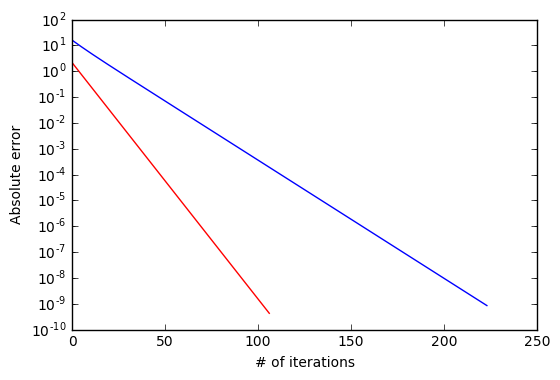

Empirical slope (b) :  -0.045633184062
Theoretical slope (b): -0.0457574905607
Empirical slope (r) :  -0.0898043867956
Theoretical slope (r): -0.0915149811214


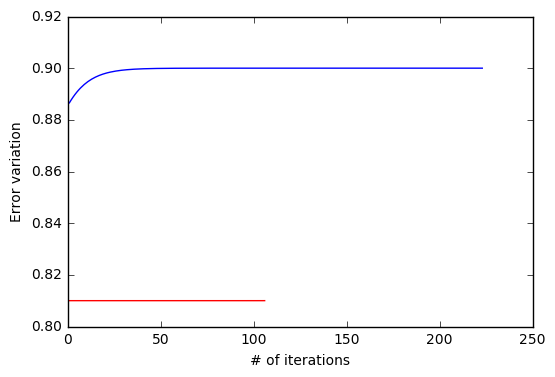

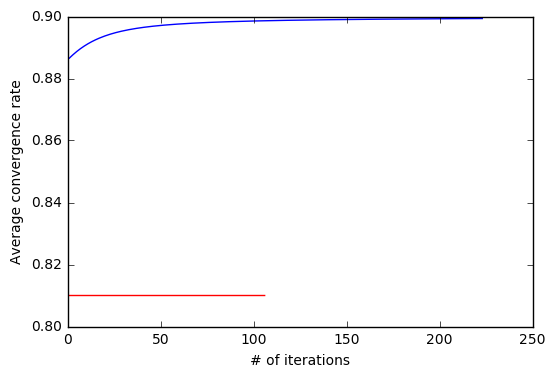

In [47]:
#compare the influence of starting point

theta = 10 ** (-10) #convergence tolerance
N=1000 #maximum number of iterations



#Run policy evaluation with usual initial value
v_approx=np.array([0.0,0.0])
print 'Usual starting point'
(v_approx,err,var_err,log_sigma,V) = policy_evaluation(gamma, P_pi, r_pi, v_approx, v_pi,theta,N,True)



#Run policy evaluation with improved initial value
v_approx=(1.0 / (1.0-gamma)) * r_pi
print '\nImproved starting point'
(v_approx_acc,err_acc,var_err_acc,log_sigma_acc,V_acc) = policy_evaluation(gamma, P_pi, r_pi, v_approx, v_pi,theta,N,True)


n1=err_acc.size
n2=err.size


#plot convergence graphs
n=np.size(err)
    
#plot infinite norm of the error, in semi-log scale
plt.semilogy(range(n2),err,'b')
plt.semilogy(range(n1),err_acc,'r')
plt.xlabel("# of iterations")
plt.ylabel("Absolute error")
plt.show()

#compute empirical slope
print "Empirical slope (b) : ", (-np.log10(err[1])+np.log10(err[n2-1]))/(n2)
print "Theoretical slope (b):", np.log10(gamma)
print "Empirical slope (r) : ", (-np.log10(err_acc[1])+np.log10(err_acc[n1-1]))/(n1)
print "Theoretical slope (r):", np.log10(gamma*e[1])

#plot variation in the error norm
plt.plot(range(1,n1),var_err_acc[range(1,n1)],'r')
plt.plot(range(1,n2),var_err[range(1,n2)],'b')
plt.xlabel("# of iterations")
plt.ylabel("Error variation")
plt.show()
    
#plot average rate of convergence
#See Section 3.2 of Varga - Matrix Iterative Analysis
plt.plot(range(1,n1),np.exp(log_sigma_acc[range(1,n1)]),'r') #empirical
plt.plot(range(1,n2),np.exp(log_sigma[range(1,n2)]),'b') #empirical
plt.xlabel("# of iterations")
plt.ylabel("Average convergence rate")
plt.show()

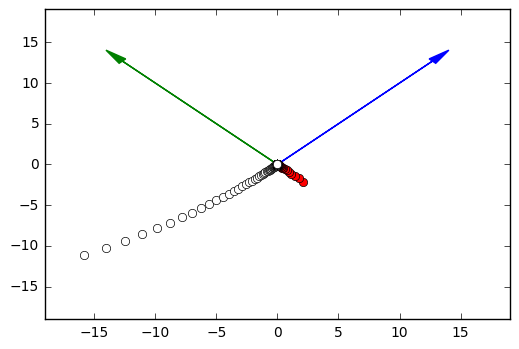

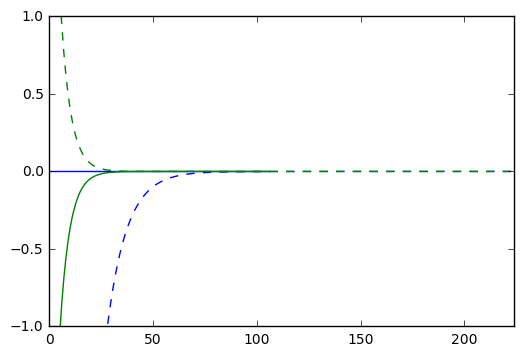

Continous line : improved starting point
Dashed line : traditional starting point


In [48]:
n=np.size(V_acc[:,0])
x_max = 1.2*np.max(np.abs(V[0,:]))

#plot convergence of value function
plt.plot(V_acc[:,0],V_acc[:,1],'ro')
plt.plot(V[:,0],V[:,1],'wo')

plt.plot([-x_max,-x_max], [x_max,x_max], color='b', linestyle='--')
plt.axis([-x_max,x_max,-x_max,x_max])
ax = plt.axes()

#plot eigenvectors of P_pi
ax.arrow(0,0,x_max/1.5,x_max/1.5,head_width=x_max/25, head_length=x_max/10,fc='b', ec='b')
ax.arrow(0,0,-x_max/1.5,x_max/1.5,head_width=x_max/25, head_length=x_max/10,fc='g', ec='g')

#plt.axes().set_aspect('equal')
plt.show()

#plot projection on eigenspaces
plt.plot(range(n1), np.dot(V_acc,v[:,0]),'b-')
plt.plot(range(n1), np.dot(V_acc,v[:,1]),'g-')

plt.plot(range(n2), np.dot(V,v[:,0]),'b--')
plt.plot(range(n2), np.dot(V,v[:,1]),'g--')
plt.axis([0,max(n1,n2),-1,1])
plt.show()
print 'Continous line : improved starting point'
print 'Dashed line : traditional starting point'